In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import logging
logging.basicConfig(level=logging.ERROR)
import numba
from numba import jit,njit, cuda
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import scipy.sparse as sp
import networkx as nx
from scipy.sparse import coo_matrix
from sklearn.metrics import roc_auc_score, f1_score, recall_score,precision_score, accuracy_score,average_precision_score,precision_recall_curve,auc
from tqdm import tqdm
import numpy as np
from torch.nn import Parameter
import torch.optim as optim
import pdb
import time
from dgllife.utils import EarlyStopping, Meter
import pickle
import re
from collections import defaultdict
import json
import hypernetx as hnx
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
# create the dictionary file from scratch
def process_text_to_dict(file_path):
    # Open and read the file
    with open(file_path, "r") as file:
        # Read the entire file content
        data = file.read()
    # Initialize a defaultdict to store graph IDs and their corresponding subgraph IDs
    graph_dict = defaultdict(list)
    
    # Split the data by the delimiter (dashed line)
    subgraphs = data.strip().split('-----------------')
    
    # Exclude the last part where the time taken is printed
    for subgraph in subgraphs[:-1]:
        lines = subgraph.strip().splitlines()
        
        # Get the subgraph ID (first line starts with 't #')
        subgraph_id = int(lines[0].split('#')[1].strip())
        
        # Get the list of graph IDs (the last line starts with 'Subgraph appears in graph IDs:')
        for line in lines:
            if line.startswith("Subgraph appears in graph IDs:"):
                graph_ids = eval(line.split(":")[1].strip())  # Safely evaluate the list
                for graph_id in graph_ids:
                    graph_dict[graph_id].append(subgraph_id)
    
    graph_dict = dict(sorted(graph_dict.items()))
    
    # Print the result
    for graph_id, subgraph_ids in graph_dict.items():
        print(f"{graph_id}: {subgraph_ids}")

    return graph_dict

# file_path = "./gspan_outputs/meaningful_subgraphs_700.txt"
file_path = "./gspan_outputs/jt_test_output_100.txt"

result = process_text_to_dict(file_path)

# Pickle the dictionary
with open('result_jt_100.pkl', 'wb') as file:
    pickle.dump(result, file)

0: [0, 1, 2, 8, 9, 10, 34, 35, 36, 37, 38, 39, 40, 44, 45, 46, 47, 48, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 76, 77, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 98, 102, 108, 109, 110, 111, 113, 114, 115, 116, 124, 125, 126, 127, 146, 147, 148, 149, 152, 153, 154, 155, 163, 164, 165, 166, 173, 174, 175, 176, 179, 180, 181, 182, 183, 184, 185, 186, 203, 204, 211, 212, 213, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 251, 252, 268]
1: [237, 238, 268, 269]
2: [0, 1, 2, 34, 35, 36, 37, 38, 44, 45, 46, 47, 55, 58, 59, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 76, 78, 81, 82, 83, 84, 85, 88, 102, 108, 113, 119, 124, 146, 147, 152, 163, 173, 179, 211, 212, 213, 237, 251]
3: [0, 1, 2, 24, 34, 35, 36, 37, 38, 45, 46, 47, 55, 58, 59, 60, 61, 63, 67, 68, 69, 70, 71, 76, 81, 82, 83, 85, 108, 113, 124, 146, 147, 152, 163, 173, 179, 211, 212, 213, 215, 237, 251, 253, 254, 272]
4: [0, 1, 2, 8, 9, 13, 24, 34, 35, 124, 125, 126, 128, 129, 130, 133, 138, 141, 157, 179, 180, 181, 185, 1

# Load dictionary files

In [42]:
# when dict in pickle format
file_path = 'result_jt_100.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)
    
# # when the dict in json format
# import json
# file_path = 'result.json'
# with open(file_path, 'r') as file:
#     DICT = json.load(file)

#  Visualizing the hypergraph

Processing edges: 100%|██████████| 10/10 [00:00<00:00, 3224.90it/s]


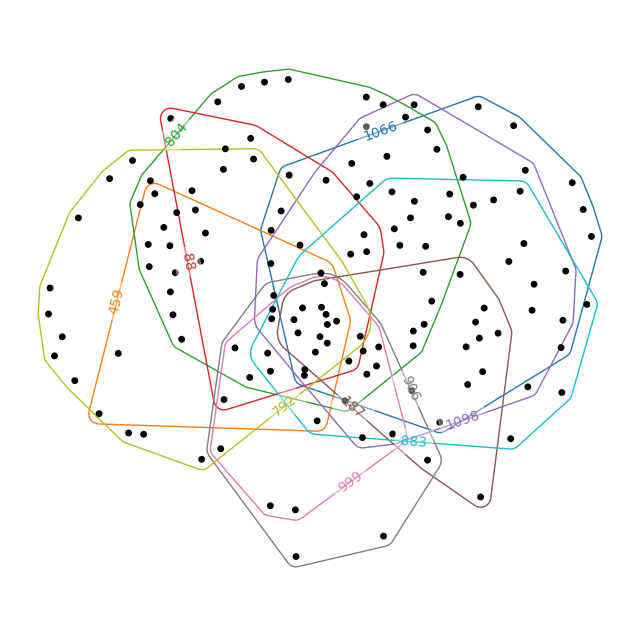

In [43]:
# Dictionary
hypergraph_dict = data

# Create the hypergraph
H = hnx.Hypergraph(hypergraph_dict)

# # Save the hypergraph to a file
# with open('hypergraph_raw_700.pkl', 'wb') as f:
#     pickle.dump(H, f)

# # Load the hypergraph from a file
# with open('hypergraph_raw_700.pkl', 'rb') as f:
#     H = pickle.load(f)

# Get the list of hyperedges
hyperedges = list(H.edges())

# Limit the number of hyperedges to be drawn
max_hyperedges = 10  # Set the desired limit
if len(hyperedges) > max_hyperedges:
    sampled_hyperedges = random.sample(hyperedges, max_hyperedges)
else:
    sampled_hyperedges = hyperedges

# Create a subset dictionary
subset_hypergraph_dict = {k: H.edges[k] for k in sampled_hyperedges}

# Create a new hypergraph using the subset
H_subset = hnx.Hypergraph(subset_hypergraph_dict)

# Draw the hypergraph
hnx.draw(H_subset, layout=nx.spring_layout, layout_kwargs={'k': 0.3, 'iterations': 50}, node_radius=0.5, node_labels_kwargs={'fontsize': 3}, edge_labels_kwargs={'fontsize': 10}, with_node_labels=False, with_edge_labels=True)
